In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch as pt 

import sys
import os
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../'))

from src.useful_functions import *
from src.modules2_1 import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)

Created variables:
inp_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/input/
dcd_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/output/trajectories/openmm_files
out_dir = /scratch/htc/fsafarov/ISOKANN_PINN/output/

cuda


In [7]:
# Get the tensor for clustering the state space

from src.clustering_metrics import*

#Atom names are deriven from pymol, we can get them from mdtraj as well

ligand_F = "resname KB8 and name F*"



pdbfile_water    = 'pdbfile_water.pdb' 
file_traj_water  = 'trajectory_water_combined6.dcd'
out_file='CF3_coords.pt'
# get_coords(
#                                     ligand_F,
#                                     inp_dir=inp_dir, 
#                                     pdb_file=pdbfile_water, 
#                                     traj_dir=dcd_dir, 
#                                     traj_file=file_traj_water, 
#                                     distances_dir=out_dir, 
#                                     out_file=out_file
#                                   )


In [8]:
frame = 0

# Load initial and final states 
pdbfile_water    = 'pdbfile_water.pdb' 
file_traj_water  = 'trajectory_water_combined6.dcd'

mdtraj =  md.load( os.path.join(dcd_dir, file_traj_water), top =os.path.join(inp_dir, pdbfile_water)).remove_solvent() 
#atoms_BB = mdtraj.topology.select("backbone")
#mdtraj = mdtraj.atom_slice(atoms_BB)

X0     = pt.load(os.path.join(out_dir, out_file), map_location=device).cpu().detach().numpy()         #  X0.shape = (N, 1) 

# Load chi function
chi0 = np.loadtxt(os.path.join(out_dir, 'chi_0.txt'))     #  chi0.shape = (Npoints,)

data           =  OrganizeData( X0, chi0, MDtraj = mdtraj)

FIs    =  FindIntervals(data, Nintervals=5, clustering = 'grid')

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
Check shape of input data
X0.shape   =  (6000, 3, 3)
chi0.shape =  (6000,)
  


In [9]:
FNs    =  FindNodes(data, FIs,  
                                eps   = [0.3, 0.25, 0.2, 0.17, 0.3],
                                theta = [8,     8,   8, 8, 8], 
                                algorithm = 'HDBSCAN', 
                                metric = 'coord_rmsd') 
print(np.sum(FNs.nodes==-1))

print("Number of nodes:", str(FNs.Nnodes))
for i in range(FNs.Nnodes):
    print("Node, interval, size:", i, FNs.index_chi_node[i], FNs.nodes_size[i])

100%|██████████| 5/5 [00:00<00:00,  5.38it/s]

665
Number of nodes: 32
Node, interval, size: 0 0 20
Node, interval, size: 1 0 12
Node, interval, size: 2 0 27
Node, interval, size: 3 0 1869
Node, interval, size: 4 0 33
Node, interval, size: 5 0 8
Node, interval, size: 6 0 35
Node, interval, size: 7 0 11
Node, interval, size: 8 0 1009
Node, interval, size: 9 0 45
Node, interval, size: 10 0 21
Node, interval, size: 11 0 8
Node, interval, size: 12 0 63
Node, interval, size: 13 1 9
Node, interval, size: 14 1 43
Node, interval, size: 15 1 15
Node, interval, size: 16 1 52
Node, interval, size: 17 1 21
Node, interval, size: 18 1 19
Node, interval, size: 19 1 13
Node, interval, size: 20 1 65
Node, interval, size: 21 1 64
Node, interval, size: 22 2 8
Node, interval, size: 23 2 980
Node, interval, size: 24 2 14
Node, interval, size: 25 3 9
Node, interval, size: 26 3 13
Node, interval, size: 27 3 23
Node, interval, size: 28 3 750
Node, interval, size: 29 3 14
Node, interval, size: 30 4 25
Node, interval, size: 31 4 37


In [10]:
#BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=128, threshold =113,algorithm='mlp')
BAM    =  BuildAdjacencyMatrix(data, FNs, FIs, metric = 'mdtraj_rmsd', include_same_interval=False, r_neighbors = 0.2)


BG     =  BuildGraph(FNs, BAM)
CE     =  CalculateEnergy(FNs)



Text(0.5, 1.0, '(b) Energy')

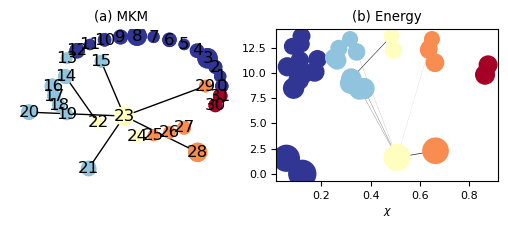

In [15]:
#posG = nx.kamada_kawai_layout(Gd)  # kamada_kawai_layout
#Make graph and nice plots

G      =  BG.G
posG = nx.kamada_kawai_layout(G, center=[0,0])  # kamada_kawai_layout

index_chi_node = FNs.index_chi_node
nodes_size     = np.log(FNs.nodes_size)*50

energy         = CE.energy
P              = BAM.P



font = {'size'   : 8}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16*in2cm, 5*in2cm), facecolor='white')

nx.draw(G, 
        posG, 
        with_labels=True, 
        node_color=index_chi_node, 
        cmap = cm.RdYlBu_r, 
        node_size= nodes_size*0.5,
        edge_color='k', 
        width=1,
        ax=ax1
       )


nx.draw_networkx_nodes(G, 
                       posG, 
                       node_size=nodes_size*0.5,
                       node_color=index_chi_node, 
                       cmap = cm.RdYlBu_r, 
                       ax=ax1)

ax1.set_title('(a) MKM')

################## PLOT ENERGY
chi_nodes = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False).ravel()


for i in range(G.number_of_nodes()):
    for j in range(i+1,G.number_of_nodes()):
        if BAM.A[i,j]>0:
            ax2.plot([chi_nodes[i], chi_nodes[j]], [energy[i], energy[j]], 'k-', linewidth = np.log(1+5*BAM.C[i,j]),zorder=-1) 



ax2.scatter(chi_nodes, energy, s = nodes_size, c = index_chi_node, cmap = cm.RdYlBu_r)

ax2.set_xlabel(r'$\chi$')
ax2.set_title('(b) Energy')

#plt.subplots_adjust(left=0, bottom=0.0, right=1, top=0.99, wspace=0.0, hspace=0.0)

# fig.savefig("output/figures/mokito.png", format='png', dpi=300, bbox_inches='tight')


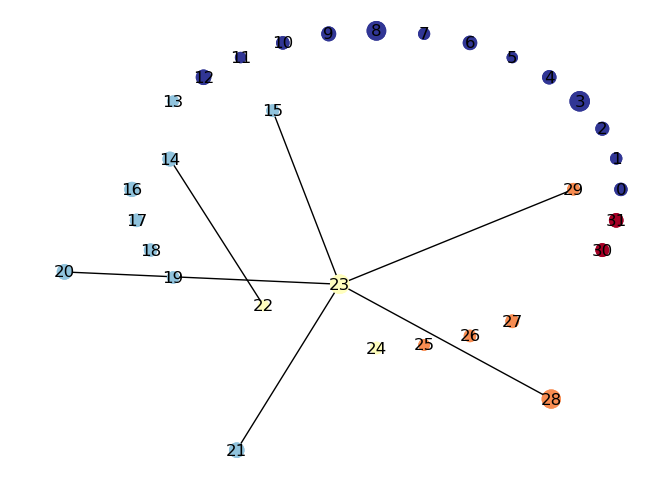

In [16]:
G      =  BG.G
posG = nx.kamada_kawai_layout(G, center=[0,0])  # kamada_kawai_layout
nx.draw(G, 
        posG, 
        with_labels=True, 
        node_color=index_chi_node, 
        cmap = cm.RdYlBu_r, 
        node_size= nodes_size*0.5,
        edge_color='k', 
        width=1,
       )


nx.draw_networkx_nodes(G, 
                       posG, 
                       node_size=nodes_size*0.5,
                       node_color=index_chi_node, 
                       cmap = cm.RdYlBu_r, 
                       )

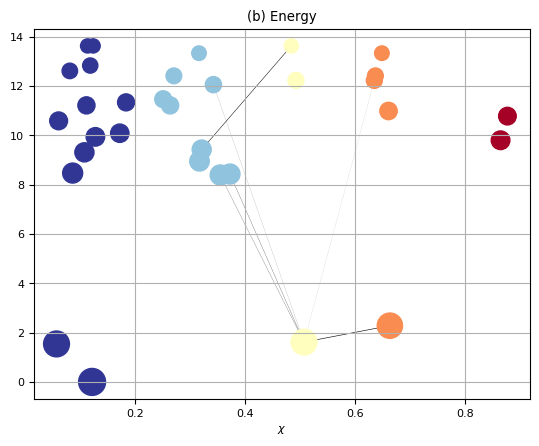

In [17]:
for i in range(G.number_of_nodes()):
    for j in range(i+1,G.number_of_nodes()):
        if BAM.A[i,j]>0:
            plt.plot([chi_nodes[i], chi_nodes[j]], [energy[i], energy[j]], 'k-', linewidth = np.log(1+5*BAM.C[i,j]),zorder=-1) 



plt.scatter(chi_nodes, energy, s = nodes_size, c = index_chi_node, cmap = cm.RdYlBu_r)

plt.xlabel(r'$\chi$')
plt.title('(b) Energy')
plt.grid()

In [19]:
from src.dash.visualization import*

pdb_file = 'pdbfile_water.pdb'
traj_file = 'trajectory_water_combined6.dcd'
selection = 'resname KB8'

app = visualize(G, FNs, pdb_file, traj_file, inp_dir, openmm_trajs, selection)

/scratch/htc/fsafarov/openmm_ff/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


ModuleNotFoundError: No module named 'src.dash_app'

In [ ]:
# ---------------------------------------------------------------------
# RUN APP in EXTERNAL BROWSER TAB
# ---------------------------------------------------------------------
if __name__ == "__main__":
    app.run(
        jupyter_mode="external",      
        debug=True,
        host="0.0.0.0",
        port=8030
    )


Dash app running on http://0.0.0.0:8030/


In [ ]:
import numpy as np
nbins = 50

hist, bin_edges = np.histogram(chi0, bins=nbins, density=True)

P = hist / np.sum(hist)

In [ ]:
kB = 0.0083144621  
T  = 300            
F = - kB * T * np.log(P)
F = F - np.min(F)


/tmp/ipykernel_10415/2627558080.py:3: RuntimeWarning:

divide by zero encountered in log



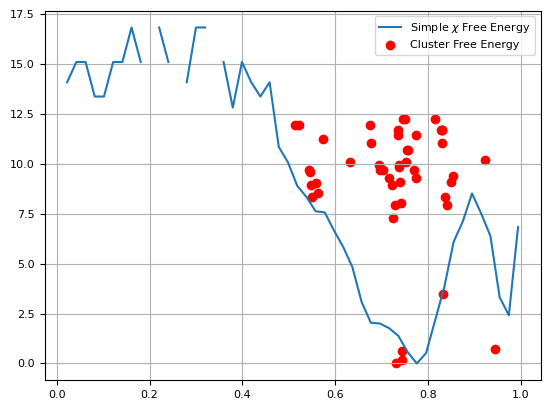

In [ ]:
import matplotlib.pyplot as plt

bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

plt.plot(bin_centers, F, label=r"Simple $\chi$ Free Energy")
plt.scatter(chi_nodes, CE.energy, c="red", label="Cluster Free Energy")
plt.legend()
plt.grid()


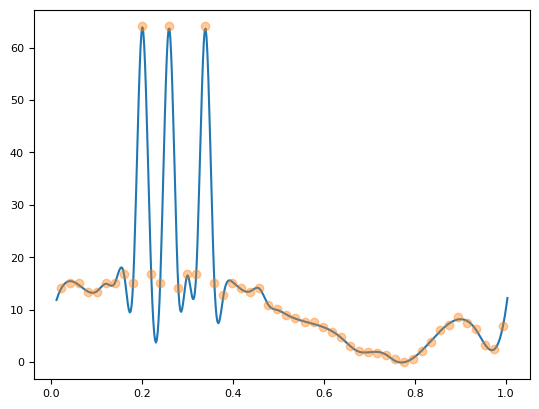

In [ ]:
from scipy.interpolate import UnivariateSpline

# histogram calculation
hist, bin_edges = np.histogram(chi0, bins=50, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
P = hist / np.sum(hist)

# avoid log(0)
P = np.clip(P, 1e-12, None)

F = -kB*T*np.log(P)
F -= np.min(F)

# smooth F
spline = UnivariateSpline(bin_centers, F, s=2.0)  # adjust smoothing
chi_grid = np.linspace(min(chi0), max(chi0), 500)

plt.plot(chi_grid, spline(chi_grid))
plt.plot(bin_centers, F, 'o', alpha=0.4)



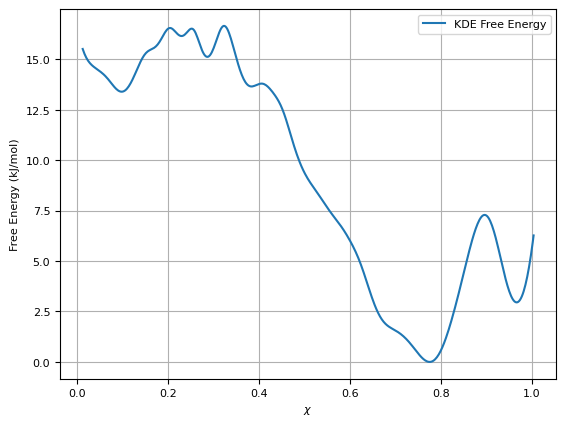

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

kde = gaussian_kde(chi0)
chi_grid = np.linspace(min(chi0), max(chi0), 500)

P_kde = kde(chi_grid)
P_kde /= np.trapezoid(P_kde, chi_grid)  # normalize properly

kB = 0.0083144621
T = 300

F_kde = -kB * T * np.log(P_kde)
F_kde -= np.min(F_kde)

plt.plot(chi_grid, F_kde, label="KDE Free Energy")
plt.xlabel(r"$\chi$")
plt.ylabel("Free Energy (kJ/mol)")
plt.grid()
plt.legend()
plt.show()


In [ ]:
mdtraj =  md.load('/scratch/htc/fsafarov/2cm2_simulation/md2/output/trajectories/openmm_files/' + file_traj_water, top = inp_dir + pdbfile_water).remove_solvent() 
ref_structure = md.load(inp_dir + pdbfile_water).remove_solvent()

def compute_rmsd(traj):
    rmsd = md.rmsd(traj, ref_structure)
    return rmsd

traj_rmsd = compute_rmsd(mdtraj)

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


In [ ]:
featurized_traj = np.array([traj_rmsd, chi0]).T

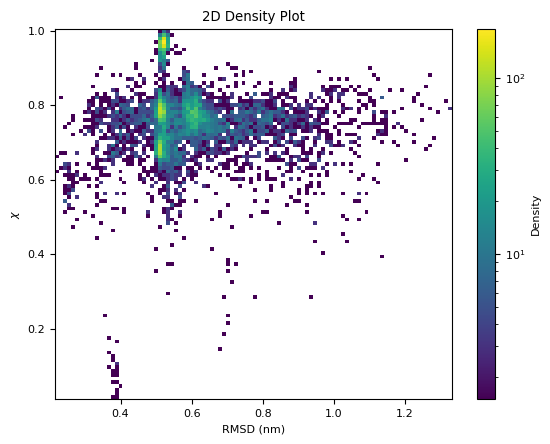

In [ ]:
# Visualize the probability density of the data in these collective variables

import matplotlib as mpl

plt.hist2d(*featurized_traj.T, bins=100, density=True, norm=mpl.colors.LogNorm(), cmap='viridis')
plt.xlabel('RMSD (nm)')
plt.ylabel(r'$\chi$')
plt.colorbar(label='Density')
plt.title('2D Density Plot')
plt.show()

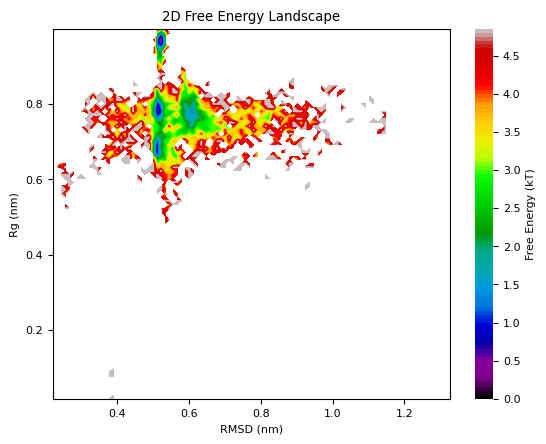

In [ ]:
# Compute and visualize the free energy in these collective variables
import deeptime
free_energy = deeptime.util.energy2d(*featurized_traj.T, bins=100)

fig, ax = plt.subplots()
deeptime.plots.plot_energy2d(free_energy, ax=ax, levels=100, contourf_kws={"cmap": plt.get_cmap("nipy_spectral")}, cbar_kws={"label": "Free Energy (kT)"})
ax.set_xlabel('RMSD (nm)')
ax.set_ylabel('Rg (nm)')
plt.title('2D Free Energy Landscape')
plt.show()